In [1]:
import pandas as pd

In [58]:
!pip install gcsfs

     |████████████████████████████████| 75 kB 4.0 MB/s eta 0:00:011
     |████████████████████████████████| 147 kB 7.4 MB/s eta 0:00:01


In [72]:
!pip install tqdm

     |████████████████████████████████| 66 kB 3.7 MB/s eta 0:00:011


In [106]:
!conda install -y dask

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/junseokpark/anaconda3/envs/kubernetes

  added / updated specs: 
    - dask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-1.18.5               |   py36hdc5ca10_0         5.0 MB  conda-forge
    toolz-0.10.0               |             py_0          46 KB  conda-forge
    tornado-6.0.4              |   py36h37b9a7d_1         639 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         146 KB  conda-forge
    pyyaml-5.3.1               |   py36h37b9a7d_0         171 KB  conda-forge
    jinja2-2.11.2              |     pyh9f0ad1d_0          93 KB  conda-forge
    cloudpickle-1.5.0          |             py_0          22 

In [2]:
df = pd.read_csv('sampleData/01581d3a-8427-41db-82c2-a7dd880a3937.rtea.txt', sep='\t')

In [3]:
## Get count of Each Class

In [3]:
df.head()

,chr,pos,ori,cnt,class,family,moreFamily,confidence,seq,isPolyA,...,hardSpl,Filter,fusion_type,tx_id,tx_biotype,gene_id.1,gene_name.1,tx_support_exon,tx_support_intron,numgap
0,1,498397,f,4,Alu,AluY,AluY:1,2,CCTTGGACAACAGAGGGAGAC,False,...,NaN,secondary;lowTEscore,exonic/exonization,ENST00000616947,lincRNA,ENSG00000237094,RP4-669L17.10,5.0,0.0,0
1,1,632543,f,680,PolyA,AluY,"AluY:7,L1HS:1",2,AAAAAAAAAACCCCCCCAAA,True,...,NaN,lowCnt;noisy;lowTEscore,exonic/exonization,ENST00000414273,unprocessed_pseudogene,ENSG00000237973,MTCO1P12,420.0,0.0,0
2,1,633792,f,1852,Alu,AluSz,AluY:3,2,CTGACCTCAAGTGATCCGCCCG,False,...,NaN,lowCnt,alternative TSS,ENST00000514057,unprocessed_pseudogene,ENSG00000248527,MTATP6P1,2458.0,0.0,0
3,1,733305,f,4,Alu,AluY,AluY:1,2,CCTTGGACAACAGAGGGAGAC,False,...,NaN,secondary;lowMapQual;lowTEscore,exonic/exonization,ENST00000506640,processed_transcript,ENSG00000228327,RP11-206L10.2,4.0,0.0,0
4,1,7969146,f,5,HERV,HERVH48I,.,2,TGAAGATGCAAAAAAAAAG,False,...,NaN,secondary;lowTEscore,exonic/exonization,ENST00000460192,retained_intron,ENSG00000116288,PARK7,3.0,45.0,55


In [4]:
list(set(df["class"]))

['HERV', 'PolyA', 'Alu', 'L1', 'SVA']

In [5]:
te_dict = {i:list(df["class"]).count(i) for i in list(df["class"])}

In [6]:
te_dict

{'Alu': 1042, 'PolyA': 136, 'HERV': 53, 'L1': 82, 'SVA': 19}

In [7]:
len(list(df["class"]))

1332

In [8]:
def countFusionsFromSample(df):
    te_dict = {i:list(df["class"]).count(i) for i in list(df["class"])}
    te_dict['total']=len(list(df["class"]))
    return te_dict

In [9]:
result_dict=countFusionsFromSample(df)

In [20]:
!pip install matplotlib

     |████████████████████████████████| 12.4 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 20.0 MB/s eta 0:00:01


In [10]:
import matplotlib.pyplot as plt
plt.bar(*zip(*result_dict.items()))
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [47]:
def removeDuplicateFromList(x):
    return list(dict.fromkeys(x))

In [48]:
from google.cloud import storage
from tqdm import tnrange, notebook

In [49]:
def checkFileExistFromBucket(bucketName,sourcePrefix,fileName):
    client = storage.Client()
    bucket = client.get_bucket(bucketName)
    blobs = bucket.list_blobs(prefix=sourcePrefix)
    result = False

    for blob in blobs:
        fileNameInBucket = blob.name.split('/')[-1]
        #print(fileNameInBucket)
        if fileNameInBucket == fileName:
            result = True

    return result

In [50]:
def getListDirectoriesFromBucket(bucketName,sourcePrefix):    
    client = storage.Client()
    bucket = client.get_bucket(bucketName)
    blobs = bucket.list_blobs(prefix=sourcePrefix)

    result = []
    index = 1
    if sourcePrefix == "":
        index = 0
        sourcePrefix = "/"
    
    #for blob in notebook.tqdm(blobs, desc='searching directories of '+sourcePrefix):
    for blob in blobs:
        DirectoryNameInBucket = blob.name.split('/')[index]
        #print(DirectoryNameInBucket)
        # Check ext
        result.append(DirectoryNameInBucket)

    result = removeDuplicateFromList(result)
    return result

In [51]:
def downloadDirectoryFromBucket(bucketName,sourcePrefix,downloadPath):
    client = storage.Client()
    bucket = client.get_bucket(bucketName)
    blobs = bucket.list_blobs(prefix=sourcePrefix)
    if downloadPath[-1] != '/':
        downloadPath=downloadPath+'/'

    mkPath(downloadPath)

    for blob in blobs:
        filename = blob.name.split('/')[-1]
        blob.download_to_filename(downloadPath + filename)
        print(
            "Blob {} downloaded to {}. ".format(
                filename,downloadPath+filename
            )
        )
        

In [52]:
# set credential as env
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/junseokpark/Dropbox/Development/IdeaProjects/TENeoantigen/rtea/kubernetes/aleelab-ten-key.json"

In [53]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

#from dask.distributed import Client, progress
#client = Client(threads_per_worker=4, n_workers=1, scheduler_port=8786)
#client

Client Scheduler: tcp://127.0.0.1:50679 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 68.72 GB


In [35]:
def getSampleResultDict(bucketName,sampleGroup,sampleId):
    result_dict ={}
    check = checkFileExistFromBucket(bucketName,sampleGroup+"/"+sampleId,sampleId+".rtea.txt") 
        
    if check:

        #print(sampleId)
        #resultCounts=resultCounts+1
        #rowNum = rowNum+1

        source_df = pd.read_csv('gs://'+bucketName+'/'+sampleGroup+'/'+sampleId+'/'+sampleId+".rtea.txt", sep='\t')

        # Filters
        # (1) Fusion Type (Omitted)
        # (2) Txbiotype = protein_coding
        if 'fusion_tx_biotype' in source_df.columns:
            source_df.rename(columns = {'fusion_tx_biotype':'tx_biotype'}, inplace=True)


        source_df = source_df[source_df['tx_biotype'].str.contains("protein_coding", na=False)]
        # (3) Filter = PASS
        source_df = source_df[source_df['Filter'].str.contains("PASS", na=False)]
        
        # Location Processing(?)
        
        # Other matrix values from here
        

        if len(source_df) > 0:
            result_dict["sampleId"]=sampleId
            result_dict["sampleGroup"]=sampleGroup
            result_dict.update(countFusionsFromSample(source_df))
            
    return result_dict



#sampleGroups = ["COAD","READ","STAD"]
import dask

bucketName="aleelab-ten-tcga-results"
#sampleGroups = ["COAD"]
future_sampleGroups=client.submit(getListDirectoriesFromBucket, bucketName, "")
sampleGroups = client.gather(future_sampleGroups)


lazy_rows_list = []
for sampleGroup in notebook.tqdm(sampleGroups, desc='sampleGroups'):
    
    if sampleGroup == 'ESCA-recovery' or sampleGroup == 'test':
        continue
    
    #sampleIds = getListDirectoriesFromBucket(bucketName, sampleGroup)
    
    future_sampleIds = client.submit(getListDirectoriesFromBucket, bucketName, sampleGroup)
    sampleIds = client.gather(future_sampleIds)
    
    #print(len(sampleIds))
    resultCounts=0
    for sampleId in notebook.tqdm(sampleIds, desc='sampleIds of '+sampleGroup):

        lazy_dict = dask.delayed(getSampleResultDict)(bucketName,sampleGroup,sampleId)
        #if len(lazy_dict) > 0:
        lazy_rows_list.append(lazy_dict)
        

#print(rows_list)
rows_list = dask.compute(*lazy_rows_list)
#countedDF=pd.DataFrame(rows_list)



TypeError: Truth of Delayed objects is not supported

In [34]:
rows_list

({},
 {'sampleId': '06ebee53-f158-49d7-baf2-6910780f023b',
  'sampleGroup': 'ACC',
  'SVA': 1,
  'Alu': 5,
  'HERV': 1,
  'PolyA': 1,
  'total': 8},
 {'sampleId': '0820ab39-407d-4326-8482-9c0c0fcc66f6',
  'sampleGroup': 'ACC',
  'PolyA': 1,
  'SVA': 1,
  'Alu': 7,
  'L1': 2,
  'total': 11},
 {'sampleId': '084af283-eb9b-4327-add2-04227e78aff9',
  'sampleGroup': 'ACC',
  'Alu': 24,
  'SVA': 5,
  'HERV': 1,
  'total': 30},
 {'sampleId': '0cbbae7f-c50f-43ed-8b3e-da334238a5bb',
  'sampleGroup': 'ACC',
  'Alu': 18,
  'HERV': 2,
  'SVA': 2,
  'total': 22},
 {'sampleId': '0ecde3de-4840-4090-9041-201e9d8bd162',
  'sampleGroup': 'ACC',
  'Alu': 2,
  'total': 2},
 {},
 {'sampleId': '11e51bf3-39c0-459c-978c-d8c2e8a7e524',
  'sampleGroup': 'ACC',
  'PolyA': 1,
  'Alu': 18,
  'L1': 1,
  'total': 20},
 {'sampleId': '122f132f-a667-400c-ad54-025b84f753ab',
  'sampleGroup': 'ACC',
  'Alu': 8,
  'SVA': 2,
  'PolyA': 1,
  'total': 11},
 {'sampleId': '129991af-5ccc-4aea-be5c-fd2160a609d5',
  'sampleGroup':

In [36]:
result_rows = filter(None,rows_list)

In [37]:
result_rows

In [38]:
countedDF=pd.DataFrame(result_rows)

In [42]:
countedDF=countedDF.fillna(0)

In [44]:
countedDF.to_csv('sampleResults-20200715.csv',header=True)

In [2]:
countedDF = pd.read_csv('sampleResults-20200715.csv')

In [3]:
countedDF.head()

,Unnamed: 0,sampleId,sampleGroup,SVA,Alu,HERV,PolyA,total,L1
0,0,06ebee53-f158-49d7-baf2-6910780f023b,ACC,1.0,5.0,1.0,1.0,8,0.0
1,1,0820ab39-407d-4326-8482-9c0c0fcc66f6,ACC,1.0,7.0,0.0,1.0,11,2.0
2,2,084af283-eb9b-4327-add2-04227e78aff9,ACC,5.0,24.0,1.0,0.0,30,0.0
3,3,0cbbae7f-c50f-43ed-8b3e-da334238a5bb,ACC,2.0,18.0,2.0,0.0,22,0.0
4,4,0ecde3de-4840-4090-9041-201e9d8bd162,ACC,0.0,2.0,0.0,0.0,2,0.0


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
!pip install seaborn

     |████████████████████████████████| 215 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 18.4 MB/s eta 0:00:01


In [5]:
countedDFSub = countedDF[["sampleGroup","SVA","Alu","HERV","PolyA","total","L1"]]

In [6]:
countedDFSub.groupby(['sampleGroup']).agg(['mean'])

,SVA,Alu,HERV,PolyA,total,L1
,mean,mean,mean,mean,mean,mean
sampleGroup,,,,,,
ACC,1.125000,14.984375,1.328125,0.515625,18.406250,0.453125
BLCA,0.987469,20.528822,2.020050,0.817043,28.709273,4.355890
CESC,1.861210,24.822064,2.508897,1.007117,32.750890,2.551601
COAD,0.756923,18.630769,0.258462,0.744615,21.683077,1.292308
GBM,1.988372,119.319767,6.238372,2.424419,132.546512,2.575581
HNSC,2.737060,20.819876,2.337474,0.807453,30.751553,4.049689
KICH,1.519231,35.153846,3.711538,1.384615,42.500000,0.730769
KIRP,1.620438,24.514599,2.029197,0.828467,29.952555,0.959854


In [7]:
countedDFSub.groupby(['sampleGroup']).agg(['mean','sum','count'])

SVA                       Alu                      HERV  \
                 mean     sum count        mean      sum count       mean   
sampleGroup                                                                 
ACC          1.125000    72.0    64   14.984375    959.0    64   1.328125   
BLCA         0.987469   394.0   399   20.528822   8191.0   399   2.020050   
CESC         1.861210   523.0   281   24.822064   6975.0   281   2.508897   
COAD         0.756923   246.0   325   18.630769   6055.0   325   0.258462   
GBM          1.988372   342.0   172  119.319767  20523.0   172   6.238372   
HNSC         2.737060  1322.0   483   20.819876  10056.0   483   2.337474   
KICH         1.519231    79.0    52   35.153846   1828.0    52   3.711538   
KIRP         1.620438   444.0   274   24.514599   6717.0   274   2.029197   
LAML         1.234043   174.0   141   33.631206   4742.0   141   1.262411   
LIHC         0.843434   334.0   396   21.414141   8480.0   396   1.555556   
LUAD         1.053360   533.0   506   21.452569  10855.0   506   2.094862   
LUSC         1.823529   806.0   442   29.764706  13156.0   442   2.395928   
OV           6.304469  2257.0   358  238.818436  85497.0   358  10.891061   
PRAD         0.890688   440.0   494   26.842105  13260.0   494   2.917004   
READ         0.800000    76.0    95   19.305263   1834.0    95   1.947368   
SARC         1.032787   252.0   244   18.836066   4596.0   244   1.983607   
SKCM         1.448000   543.0   375   24.405333   9152.0   375   1.890667   
STAD         3.515493  1248.0   355  177.808451  63122.0   355   6.676056   
TGCT         5.788462   903.0   156   22.551282   3518.0   156   5.628205   
THYM         1.162393   136.0   117   25.487179   2982.0   117   2.222222   
UCEC         1.441624   284.0   197   18.065990   3559.0   197   2.619289   

                               PolyA                     total               \
                sum count       mean     sum count        mean    sum count   
sampleGroup                                                                   
ACC            85.0    64   0.515625    33.0    64   18.406250   1178    64   
BLCA          806.0   399   0.817043   326.0   399   28.709273  11455   399   
CESC          705.0   281   1.007117   283.0   281   32.750890   9203   281   
COAD           84.0   325   0.744615   242.0   325   21.683077   7047   325   
GBM          1073.0   172   2.424419   417.0   172  132.546512  22798   172   
HNSC         1129.0   483   0.807453   390.0   483   30.751553  14853   483   
KICH          193.0    52   1.384615    72.0    52   42.500000   2210    52   
KIRP          556.0   274   0.828467   227.0   274   29.952555   8207   274   
LAML          178.0   141   0.843972   119.0   141   37.829787   5334   141   
LIHC          616.0   396   0.699495   277.0   396   26.196970  10374   396   
LUAD         1060.0   506   0.784585   397.0   506   27.371542  13850   506   
LUSC         1059.0   442   0.907240   401.0   442   43.065611  19035   442   
OV           3899.0   358  10.125698  3625.0   358  277.773743  99443   358   
PRAD         1441.0   494   0.912955   451.0   494   32.445344  16028   494   
READ          185.0    95   0.673684    64.0    95   24.084211   2288    95   
SARC          484.0   244   0.684426   167.0   244   22.954918   5601   244   
SKCM          709.0   375   0.810667   304.0   375   29.448000  11043   375   
STAD         2370.0   355   5.647887  2005.0   355  202.369014  71841   355   
TGCT          878.0   156   0.878205   137.0   156   37.442308   5841   156   
THYM          260.0   117   0.811966    95.0   117   35.017094   4097   117   
UCEC          516.0   197   0.878173   173.0   197   24.081218   4744   197   

                    L1                
                  mean     sum count  
sampleGroup                           
ACC           0.453125    29.0    64  
BLCA          4.355890  1738.0   399  
CESC          2.551601   717.0   281  
COAD          1.292308   420.0   325  

In [8]:
countedDFSubMean = countedDFSub.groupby(['sampleGroup']).mean()

In [10]:
countedDFSubMean.head()

,SVA,Alu,HERV,PolyA,total,L1
sampleGroup,,,,,,
ACC,1.125000,14.984375,1.328125,0.515625,18.406250,0.453125
BLCA,0.987469,20.528822,2.020050,0.817043,28.709273,4.355890
CESC,1.861210,24.822064,2.508897,1.007117,32.750890,2.551601
COAD,0.756923,18.630769,0.258462,0.744615,21.683077,1.292308
GBM,1.988372,119.319767,6.238372,2.424419,132.546512,2.575581


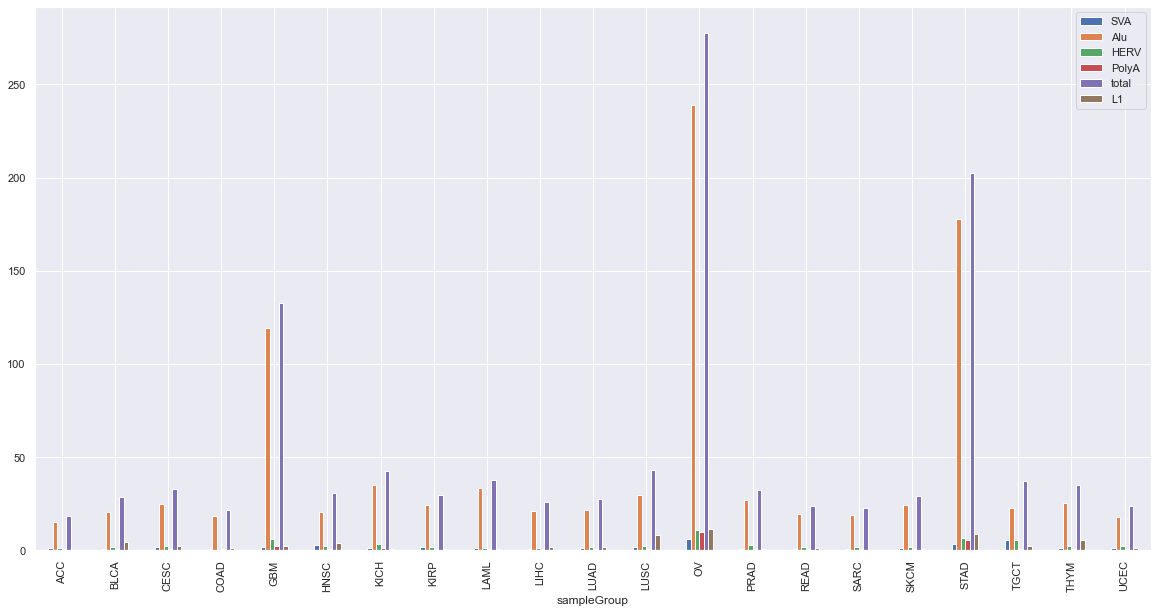

In [46]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
countedDFSubMean.plot.bar()

In [20]:
countedDFSubMean.reset_index(drop=False).head()

,sampleGroup,SVA,Alu,HERV,PolyA,total,L1
0,ACC,1.125000,14.984375,1.328125,0.515625,18.406250,0.453125
1,BLCA,0.987469,20.528822,2.020050,0.817043,28.709273,4.355890
2,CESC,1.861210,24.822064,2.508897,1.007117,32.750890,2.551601
3,COAD,0.756923,18.630769,0.258462,0.744615,21.683077,1.292308
4,GBM,1.988372,119.319767,6.238372,2.424419,132.546512,2.575581


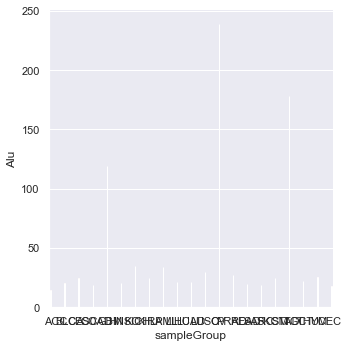

In [41]:
sns.catplot(x="sampleGroup",
           y="Alu",
           hue="sampleGroup",
           data=countedDFSubMean.reset_index(drop=False),
           kind = "bar")